# WhatsApp network traffic analyzing project
## Part B - data analyzing

### This notebook has 3 parts: 
1. **Individual Group Analysis:** In this section, we work on each group separately, distinguishing between groups with distinct primary themes and a potentially noisy group. We generate and visualize graphs to analyze the characteristics of these groups.
2. **Main Theme Group Comparison:** Here, we load all the groups characterized by primary themes and construct complementary cumulative distribution functions (CCDFs) for them. This helps us understand the distribution of certain attributes across these groups.
3. **Attacker and Attacked Relationship:** The third section involves loading recordings of interactions between attackers and those being attacked, particularly in cases where the attacked individual is actively participating in multiple groups. We aim to identify potential correlations to determine if we can discern instances where the attacked individual is in the same group as the attacker.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### Addition columns of time and packet lengths differences, and reformatting columns type


In [2]:
#time delays between 2 consecutive messages
def add_delays(df: pd.DataFrame):
    df["Time_delay"] = abs(df["Time"].diff().fillna(0)).round(6)

#packets length diffs 2 consecutive messages
def add_lengths(df: pd.DataFrame):
    df["Length_diff"] = abs(df["Length"].diff()).fillna(0)


def reformat_columns(df: pd.DataFrame):
    df["No."] = df["No."].astype(float)
    df["Time"] = df["Time"].astype(float)
    df["Length"] = df["Length"].astype(float)
    return df

### Redirection to the raw csv files folder

In [3]:
def getCleanCsv():
    # Get the current directory where your notebook is located
    current_dir = os.getcwd()

    # Construct the path to the "resources" directory
    resources_dir = os.path.join(current_dir, '..', 'resources')

    # Construct the path to the "CLEAN" directory within "resources"
    clean_csv_dir = os.path.join(resources_dir, r'CLEAN/')
    return clean_csv_dir

### Loading the required data frame

In [4]:
file_name = None

def load_csv(number):
    work_path = getCleanCsv()
    if number == '1':
        file_name = "whatsappMessagesCSV"
        path = work_path + "/" + file_name + "Clean.csv"
        print("---------Mixed Group (Mostly Messages)----------")
    elif number == '2':
        file_name = "whatsappImagesCSV"
        path = work_path + "/" + file_name + "Clean.csv"
        print("---------Images----------")
    elif number == '3':
        file_name = "whatsappAudioCSV"
        path = work_path + "/" + file_name + "Clean.csv"
        print("---------Audio----------")
    elif number == '4':
        file_name = "whatsappVideosCSV"
        path = work_path + "/" + file_name + "Clean.csv"
        print("---------Videos----------")
    elif number == '5':
        file_name = "whatsappFilesCSV"
        path = work_path + "/" + file_name + "Clean.csv"
        print("---------Files----------")
    elif number == '6':
        file_name = "WhatsappNoisedGroupCSV"
        path = work_path + "/" + file_name + "Clean.csv"
        print("---------Group With Noise----------")
    
    df = pd.read_csv(path, sep=',', header=0,
                     usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
    df = reformat_columns(df)
    add_delays(df)
    add_lengths(df)
    print(df.head())
    return df, file_name

### Visualizations

In [5]:
# Plot the message count over time using a line chart

def plot_activity_trends(df):
    plt.figure(figsize=(15, 4))
    plt.plot(df["Time"], df["Length"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Message Count and Activity Trends")
    plt.grid(True)
    plt.xticks(rotation=45, ha="right")
    plt.xlim(0, max(df["Time"]))
    plt.tight_layout()
    plt.show()

In [6]:
# Bar plot of length packet length changes in time

def bar_plot(df):
    plt.figure(figsize=(9, 4))
    plt.bar(df["Time"], df["Length"])
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [7]:
# Plot for the function 'count_length_ranges'

def plot_length_range_counts(length_range_counts):
    range_names = list(length_range_counts.keys())
    counts = list(length_range_counts.values())
    
    plt.figure(figsize=(8, 5))
    bars = plt.bar(range_names, counts)
    
    plt.xlabel("Length Range")
    plt.ylabel("Count")
    plt.title("Count of Cells in Each Length Range")
    plt.xticks(rotation=45, ha="right")
    
    # Adding counts on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 10, yval, ha='center', va='bottom', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()


In [8]:
# Plot of packet length with the frequency of this packet length

def plot_length_histogram(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.hist(df["Length"], bins=df["Length"].nunique(), edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Length Histogram")
    plt.show()

In [9]:
#filtering all packets with length above a certain threshold

def filter_length_above_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] > given]
    return filtered_df

In [10]:
#filtering all packets with length below a certain threshold

def filter_length_below_given(df: pd.DataFrame, given: int):
    filtered_df = df[df["Length"] < given]
    return filtered_df

In [11]:
# Calculates the threshold value for the y-axis size based on the data frame,
#      considering a specified number of data points above the threshold.

def compute_y_axis_size(df, num_above_threshold=3):
    num_data_points = len(df)
    num_below_threshold = num_data_points - num_above_threshold

    fraction_below_threshold = num_below_threshold / num_data_points
    y_axis_size = df['Length'].quantile(fraction_below_threshold)
    
    return y_axis_size


# Generates a bar plot with colored bars representing data attributes from the input dataframe,
#      distinguishing between different sources using colors and labeling,
#      while also considering the y-axis size determined by the compute_y_axis_size function.

def colored_bar_plot(df):
    fig, ax = plt.subplots(figsize=(15, 4))

    # Define colors for bars based on the condition
    colors = ['blue' if source != "10.0.2.15" else 'red' for source in df["Source"]]
    
    # Plot bars with the defined colors
    bars = plt.bar(df["Time"], df["Length"], color=colors)
    
    # Create custom bars for the legend
    blue_bar = plt.Rectangle((0,0),1,1,fc="blue", edgecolor='none')
    red_bar = plt.Rectangle((0,0),1,1,fc="red", edgecolor='none')
    
    # Add a legend
    l = plt.legend([blue_bar, red_bar], ['Other IPs', '10.0.0.25'], loc=1, ncol=2, prop={'size':10})
    l.draw_frame(False)
    
    y_axis_size = compute_y_axis_size(df, 3)  # Change the second argument if you want a different number above the threshold
    
    plt.xlim(0, max(df["Time"]) + 50)
    plt.ylim(0, y_axis_size)
    
    plt.yticks(np.arange(0, y_axis_size, 500))
    plt.xticks(np.arange(0, max(df["Time"]) + 50, 50))

    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    
    return y_axis_size, fig

In [12]:
def generate_pdf(df, bins=10):
    """
    Generate the Probability Density Function (PDF) for inter-arrival time.

    Args:
    - df (pd.DataFrame): The dataframe containing Time_delay column.
    - bins (int or sequence): Number of histogram bins or a sequence defining the bin edges.

    Returns:
    - bin_edges (ndarray): The bin edges (length nbins + 1).
    - pdf (ndarray): The values of the PDF.
    """
    
    # Create a histogram of the Time_delay
    counts, bin_edges = np.histogram(df['Time_delay'], bins=bins, density=True)
    
    # Convert counts to probabilities
    pdf = counts / sum(counts)
    
    return bin_edges, pdf

def exponential_dist(x, lambd, scale_factor):
    return scale_factor * lambd * np.exp(-lambd * x)

def plot_pdf_with_fitted_exponential(df, bin_edges, pdf):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotting the outline of the histogram using ax.step
    ax.step(bin_edges[:-1], pdf, where='post', color='blue', lw=2, label='PDF')
    
    # Estimate lambda (rate parameter) from the data
    lambd = 1. / np.mean(df['Time_delay'])
    
    # Compute the bin width from the first two bin edges
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Adjust the scale_factor with respect to bin_width
    scale_factor = max(pdf) / (lambd * np.exp(-lambd * bin_edges[np.argmax(pdf)]))
    
    # Create x values for the fitted exponential curve
    x = np.linspace(0, max(bin_edges), 500)
    
    # Calculate exponential distribution values using the estimated lambda
    y = exponential_dist(x, lambd, scale_factor)
    
    ax.plot(x, y, color='red', lw=2, label='Fitted Exponential Distribution')
    
    ax.set_xlabel('Inter-Arrival Time')
    ax.set_ylabel('Density')
    ax.set_title('PDF of Inter-Arrival Time and Fitted Exponential Distribution')
    ax.legend()
    ax.grid(True)
    plt.show()
    return fig

In [13]:
def plot_time_delay_over_time(df):
    plt.figure(figsize=(10, 6))
    
    plt.bar(df['Time'], df['Time_delay'], color='b')
    
    plt.xlabel('Time')
    plt.ylabel('Time Delay')
    plt.title('Time Delay over Time')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### Main run function 

Please select which Whatsapp Group you want to clean:
1 - Mixed messages (a bit from everything)
2 - Mostly Images
3 - Mostly Audio
4 - Mostly videos
5 - Mostly Files
6 - Noisy recording
7 - Exit
3
---------Audio----------
    No.      Time          Source     Destination Protocol  Length  \
0   1.0  0.000000       10.0.2.15  157.240.214.60  TLSv1.2   413.0   
1   3.0  0.076831  157.240.214.60       10.0.2.15      TCP  1446.0   
2   7.0  3.435388       10.0.2.15  157.240.214.60  TLSv1.2   124.0   
3   9.0  4.648562       10.0.2.15  157.240.214.60  TLSv1.2   269.0   
4  11.0  4.808730       10.0.2.15  157.240.214.60  TLSv1.2   124.0   

                                                Info  Time_delay  Length_diff  
0                                   Application Data    0.000000          0.0  
1  443  >  35260 [PSH, ACK] Seq=1 Ack=360 Win=655...    0.076831       1033.0  
2                                   Application Data    3.358556       1322.0  
3                                   

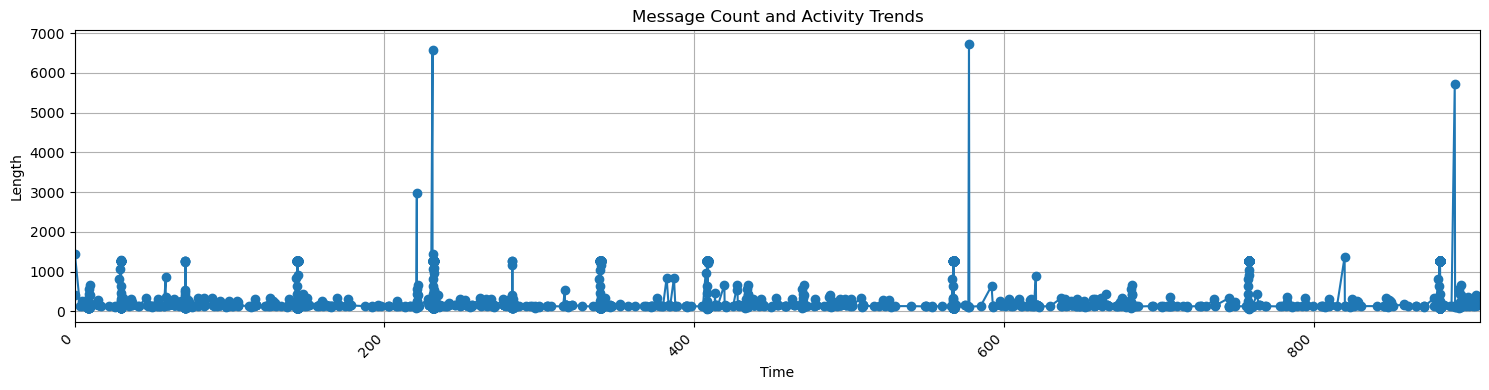

In [14]:
isvalid = True
while isvalid:
    answer = input("Please select which Whatsapp Group you want to clean:\n"
                           "1 - Mixed messages (a bit from everything)\n"
                           "2 - Mostly Images\n"
                           "3 - Mostly Audio\n"
                           "4 - Mostly videos\n"
                           "5 - Mostly Files\n"
                           "6 - Noisy recording\n"
                           "7 - Exit\n")
    options = ['1','2','3','4','5','6','7']
    if answer not in options:
        print("Invalid value. Please enter a valid number\n")
    elif answer == '7':
        isvalid = False
        print("Goodbye")
    else:
        isvalid = False
        df, name = load_csv(answer)
        plot_activity_trends(df)

**We will present the packets divided into the source and the rest of the addresses, to identify what the victim sent**

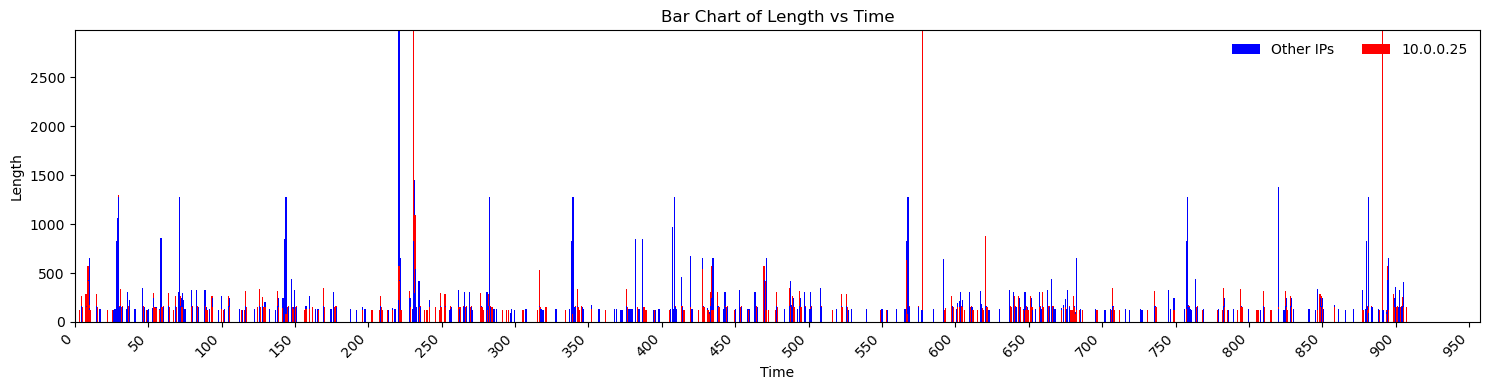

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
568,1147.0,231.021375,10.0.2.15,157.240.214.60,TLSv1.2,6581.0,Application Data,0.978846,6450.0
1769,2947.0,577.438892,10.0.2.15,157.240.214.60,TLSv1.2,6734.0,Application Data,0.430866,6609.0
2687,4283.0,891.110688,10.0.2.15,157.240.214.60,TLSv1.2,5726.0,Application Data,2.090165,5602.0


In [15]:
threshold, fig = colored_bar_plot(df)
df[df["Length"]>threshold]

**The assumption is whenever a big document/ video/ image etc. is sent - there will be a group of consecutive small delays due to that the transport layer dividing the data and sending it in a few packets one after another**

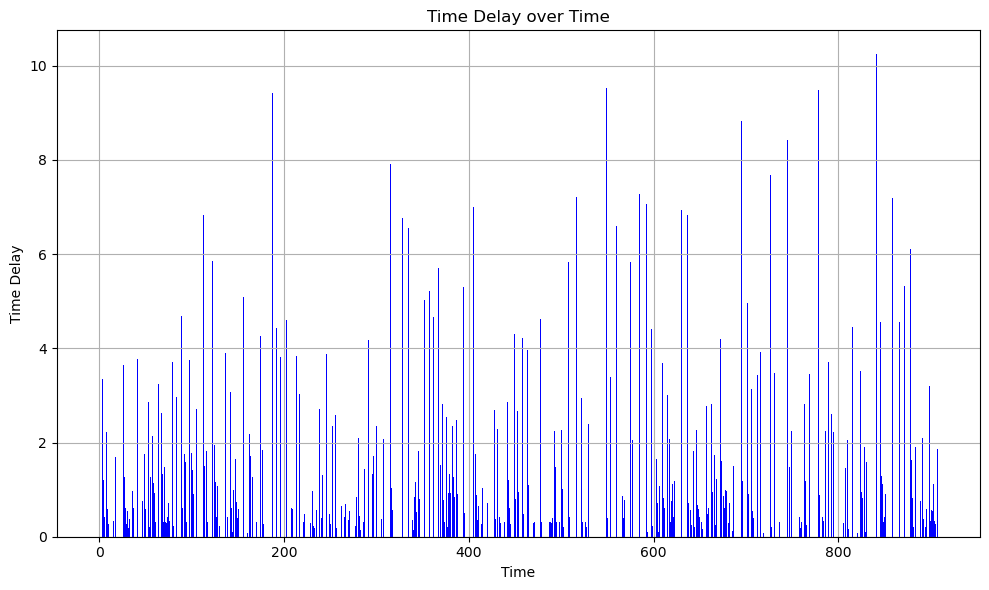

In [16]:
plot_time_delay_over_time(df)

**We would like to be impressed by the number of large packets, as well as the sizes of most packets according to the ranges we have chosen**

In [17]:
#counting the sizes of packets (num of packets in a certain ranges) 
def count_length_ranges(df: pd.DataFrame):
    ranges = {
        "0-50": (0, 50),
        "51-100": (51, 100),
        "100-500": (101, 500),
        "501-1000": (501, 1000),
        "1001-1500": (1001, 1500),
        "1501-2500": (1501, 2500),
        ">1500": (2501, float("inf"))
    }
    
    range_counts = {range_name: 0 for range_name in ranges}
    
    for range_name, (lower, upper) in ranges.items():
        range_counts[range_name] = ((df["Length"] >= lower) & (df["Length"] <= upper)).sum()
    
    return range_counts

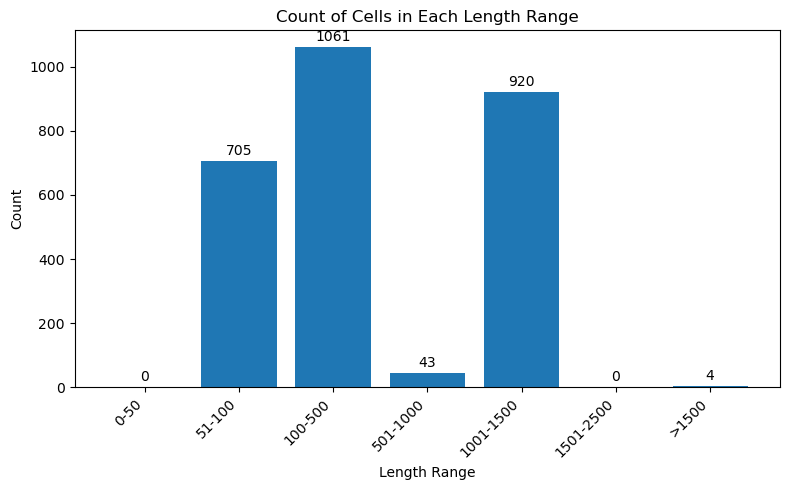

In [18]:
length_range_counts = count_length_ranges(df)
plot_length_range_counts(length_range_counts)

#### Statistical analysis

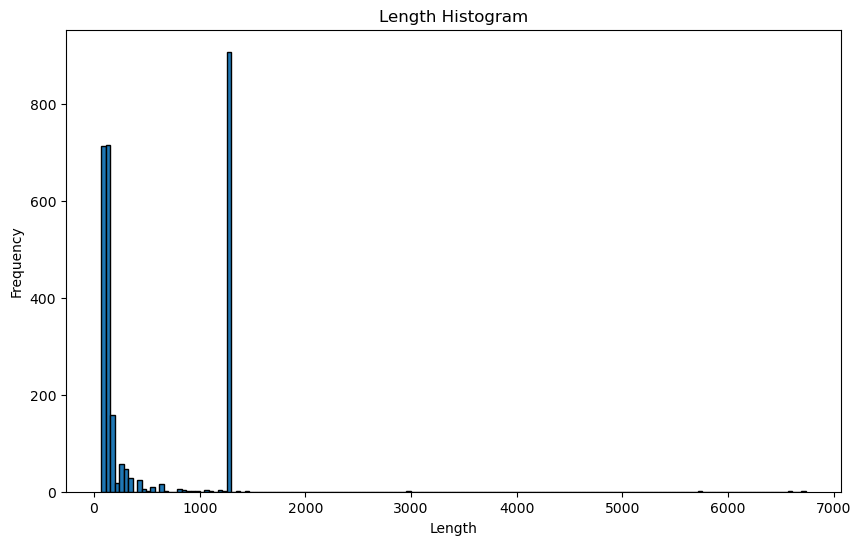

Index of the max packet length: 1769
The max packet length value: 6734.0


In [19]:
plot_length_histogram(df)
print ("Index of the max packet length:", np.argmax(df["Length"]))
print ("The max packet length value:", np.max(df["Length"]))

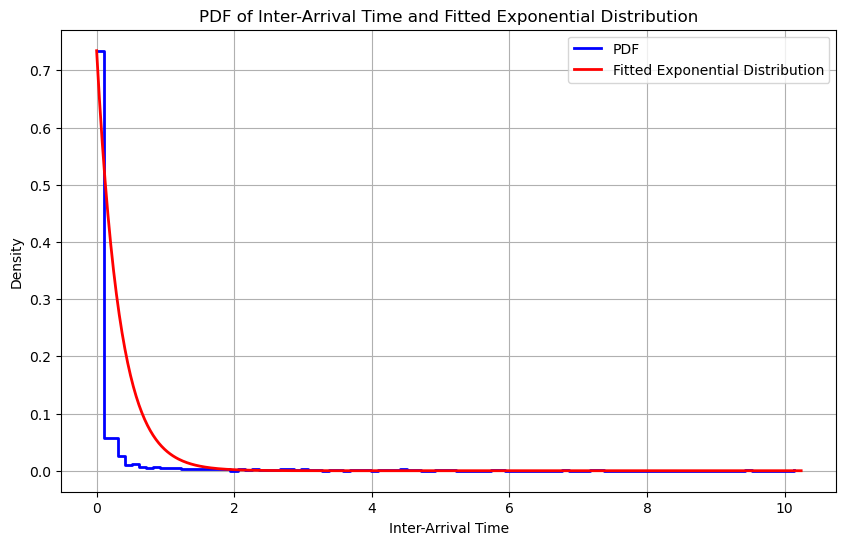

In [20]:
bin_edges, pdf = generate_pdf(df, bins=100)
fig = plot_pdf_with_fitted_exponential(df, bin_edges, pdf)

In [21]:
df[df["Time_delay"]<0]

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff


In [22]:
def getResDir():
     # Get the current directory where your notebook is located
    current_dir = os.getcwd()
    
    # Construct the path to the "resources" directory
    res_dir = os.path.join(current_dir, '..', 'res')
    return res_dir

In [23]:
def save_required_graphs(df, name):
    _, fig1 = colored_bar_plot(df)
    bin_edges, pdf = generate_pdf(df, bins=100)
    fig2 = plot_pdf_with_fitted_exponential(df, bin_edges, pdf)
    
    res_dir = getResDir()
    
    # Filepaths for the figures
    fig1_filepath = os.path.join(res_dir+"\LengthVsTime" , f"{name}lengthVsTime.png")
    fig2_filepath = os.path.join(res_dir+"\PDF", f"{name}pdfWithFittedExponential.png")
    
    # Save the figures
    fig1.savefig(fig1_filepath)
    fig2.savefig(fig2_filepath)

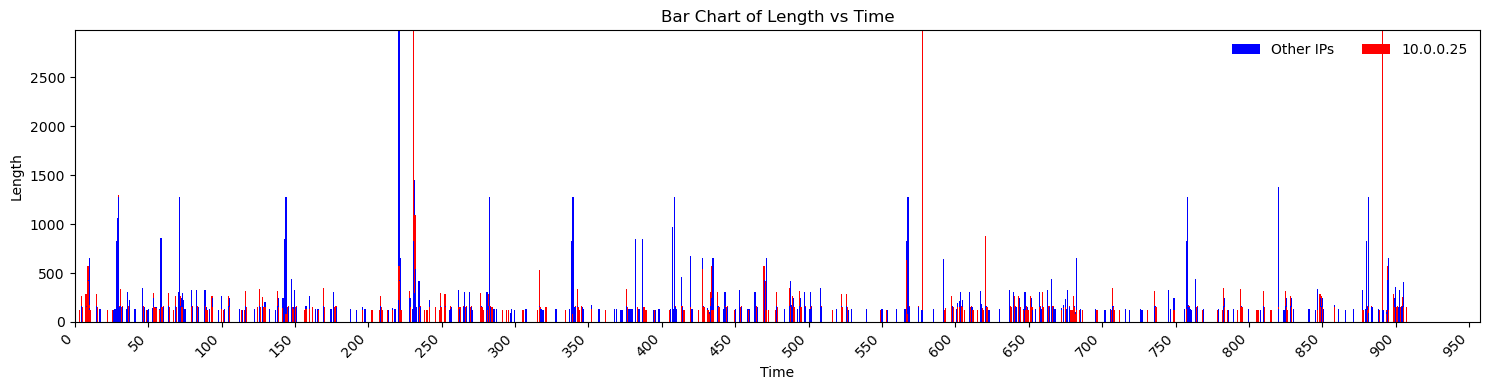

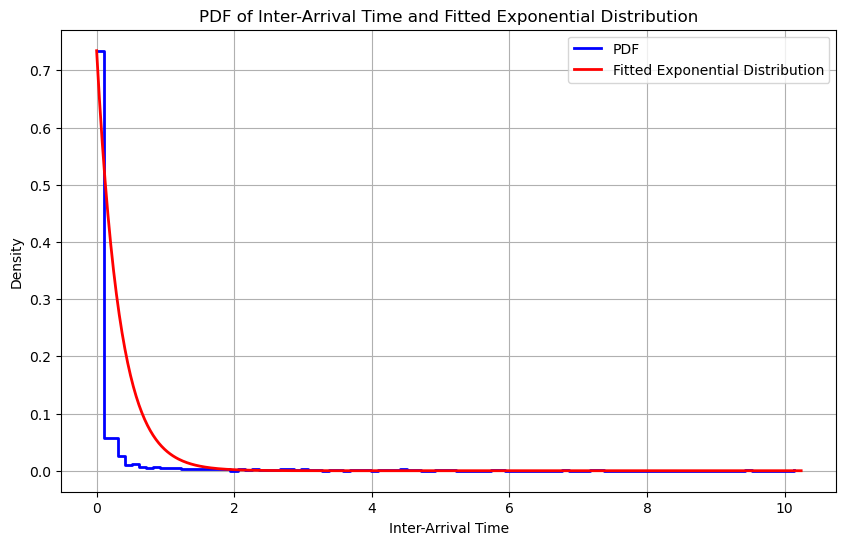

In [24]:
save_required_graphs(df, name)

## In this part we will look on all the groups with main theme and compute the CCDF for them

In [25]:
def load_all():
    dataframes = []
    lst = ['1','2','3','4','5']
    for df_i in lst:
        df, name = load_csv(df_i)
        dataframes.append(df)
    return dataframes

In [26]:
def compute_ccdf(column, big_threshold=0.7):  
    """Compute CCDF for a given dataframe column."""
    # Sort and normalize the data
    sorted_vals = np.sort(column)
    normalized_vals = sorted_vals / max(sorted_vals)

    # Compute CDF and then CCDF
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    ccdf = 1 - cdf
    
    return [normalized_vals, ccdf]

def plot_ccdf(dataframes, labels):
    """Plot CCDF for a list of dataframes (considering their 'Length' column)."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i in range(5):
        normalized_vals, ccdf = compute_ccdf(dataframes[i]["Length"])
        plt.plot(normalized_vals, ccdf, label=labels[i])
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Normalized Message Sizes')
    plt.ylabel('CCDF')
    plt.title('CCDF of Packets Size Distribution')
    plt.legend(loc="lower left")
    plt.show()
    return fig

---------Mixed Group (Mostly Messages)----------
   No.      Time          Source     Destination Protocol  Length  \
0  1.0  0.000000  157.240.196.60       10.0.2.15  TLSv1.2   310.0   
1  3.0  0.383493       10.0.2.15  157.240.196.60  TLSv1.2   150.0   
2  5.0  0.524647  157.240.196.60       10.0.2.15  TLSv1.2   166.0   
3  7.0  0.632557       10.0.2.15  157.240.196.60  TLSv1.2   154.0   
4  9.0  0.965864  157.240.196.60       10.0.2.15  TLSv1.2   131.0   

               Info  Time_delay  Length_diff  
0  Application Data    0.000000          0.0  
1  Application Data    0.383493        160.0  
2  Application Data    0.141155         16.0  
3  Application Data    0.107910         12.0  
4  Application Data    0.333307         23.0  
---------Images----------
   No.      Time          Source     Destination Protocol  Length  \
0  1.0  0.000000  157.240.214.60       10.0.2.15  TLSv1.2   134.0   
1  3.0  1.047416       10.0.2.15  157.240.214.60  TLSv1.2   122.0   
2  5.0  2.096667     

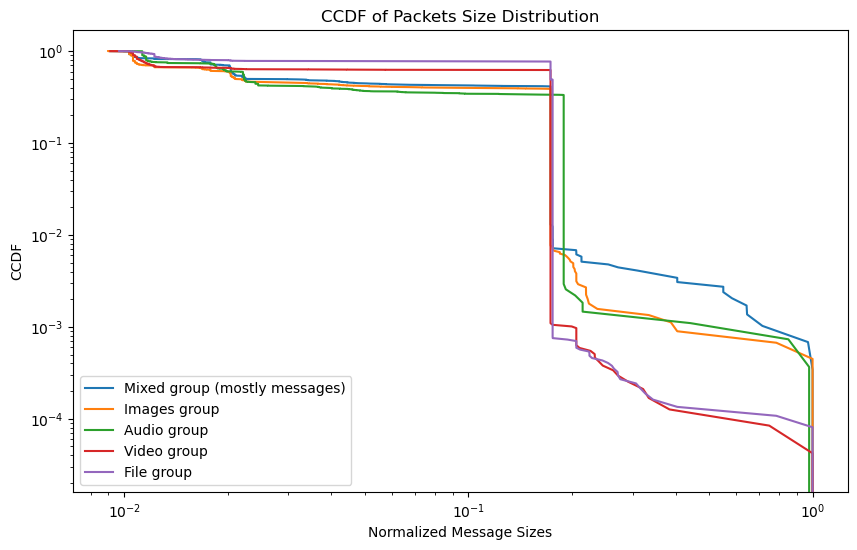

In [27]:
df1, df2, df3, df4, df5 = load_all()

dfs = [df1, df2, df3, df4, df5]

labels = ['Mixed group (mostly messages)', 'Images group', 'Audio group', 'Video group', 'File group']

fig = plot_ccdf(dfs, labels)

res_dir = getResDir()
path = os.path.join(res_dir+"\ChrachteristicsOfAllGroups\whatsappComunicationTypesCCDF.png")
fig.savefig(path)

In [28]:
df_mixed, df_images, df_audio, df_videos, df_files = df1, df2, df3, df4, df5

In [29]:
dfs = {'Images': df_images, 'Audio': df_audio, 'Videos': df_videos, 'Files': df_files, 'Mixed': df_mixed}

for name, df in dfs.items():
    print(name)
    print("Mean:", df["Length"].mean())
    print("Median:", df["Length"].median())
    print("Variance:", df["Length"].var())
    # Add more statistics as required
    print("------")

Images
Mean: 590.2623097582812
Median: 155.0
Variance: 357531.59180052264
------
Audio
Mean: 533.593487010611
Median: 150.0
Variance: 331351.81601905805
------
Videos
Mean: 832.1665263866678
Median: 1274.0
Variance: 331890.62691191706
------
Files
Mean: 1019.8986271870795
Median: 1274.0
Variance: 249270.16695546694
------
Mixed
Mean: 638.8996929375639
Median: 166.0
Variance: 393327.1162149332
------


In [30]:
window_size = 10  # You can adjust this
for name, df in dfs.items():
    df['rolling_avg_length'] = df['Length'].rolling(window=window_size).mean()
    print(name, "Mean Rolling Average Length:", df['rolling_avg_length'].mean())

Images Mean Rolling Average Length: 591.1035209688248
Audio Mean Rolling Average Length: 534.3432085168849
Videos Mean Rolling Average Length: 832.4223003410125
Files Mean Rolling Average Length: 1020.1047844700307
Mixed Mean Rolling Average Length: 640.3060574948666


## Now, we will take a look on a group where the attacked user is active in multiple groups

In [31]:
def read_together():
    work_path = getCleanCsv()
    path1 = work_path + "/whatsappAttackedRegularUseCSVClean.csv"
    path2 = work_path + "/whatsappAttackerRegularUseCSVClean.csv"
    
    df1 = pd.read_csv(path1)
    df2 = pd.read_csv(path2)
    
    return df1, df2

In [32]:
def together_bar_plot(df1, df2):
    plt.figure(figsize=(9, 4))
    
    # Colors and plot for df1
    colors_df1 = ['blue' if source != "10.0.2.15" else 'red' for source in df1["Source"]]
    plt.bar(df1["Time"], df1["Length"], color=colors_df1, label='DataFrame1', alpha=0.6)
    
    # Colors and plot for df2
    colors_df2 = ['green' if source != "10.0.2.15" else 'yellow' for source in df2["Source"]]
    plt.bar(df2["Time"], df2["Length"], color=colors_df2, label='DataFrame2', alpha=0.6)
    
    # Create custom bars for the legend
    blue_bar = plt.Rectangle((0,0),1,1,fc="blue", edgecolor='none')
    red_bar = plt.Rectangle((0,0),1,1,fc="red", edgecolor='none')
    green_bar = plt.Rectangle((0,0),1,1,fc="green", edgecolor='none')
    yellow_bar = plt.Rectangle((0,0),1,1,fc="yellow", edgecolor='none')
    
    # Add a legend
    l = plt.legend([blue_bar, red_bar, green_bar, yellow_bar], 
                   ['DF1 Other IPs', 'DF1 10.0.2.15', 'DF2 Other IPs', 'DF2 10.0.2.15'], 
                   loc=1, ncol=2, prop={'size':10})
    l.draw_frame(False)
    
    combined_df = pd.concat([df1, df2])
    y_axis_size = compute_y_axis_size(combined_df, 3)
    
    plt.xlim(0, max(combined_df["Time"]) + 50)
    plt.ylim(0, y_axis_size)
    
    plt.yticks(np.arange(0, y_axis_size, 500))
    plt.xticks(np.arange(0, max(combined_df["Time"]) + 50, 50))

    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    return y_axis_size

In [33]:
def plot_bar_graphs(df1, df2):
    # Filtering conditions
    df1_source_10 = df1[df1['Source'] == '10.0.2.15']
    df2_source_10 = df2[df2['Source'] == '10.0.2.15']
    df1_source_not_10 = df1[df1['Source'] != '10.0.2.15']
    df2_source_not_10 = df2[df2['Source'] != '10.0.2.15']
    
    plt.figure(figsize=(15, 15))

    # Graph 1: df1 is 10.0.2.15 and df2 is not 10.0.2.15
    plt.subplot(3, 1, 1)
    plt.bar(df1_source_10['Time'], df1_source_10['Length'], color='r', label='df1: Source=10.0.2.15')
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='df2: Source!=10.0.2.15')
    plt.legend()
    plt.title('Source from df1 is 10.0.2.15 and source from df2 is NOT 10.0.2.15')
    plt.xlabel('Time')
    plt.ylabel('Length')

    # Graph 2: df2 is 10.0.2.15 and df1 is not 10.0.2.15
    plt.subplot(3, 1, 2)
    plt.bar(df2_source_10['Time'], df2_source_10['Length'], color='b', label='df2: Source=10.0.2.15')
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='df1: Source!=10.0.2.15')
    plt.legend()
    plt.title('Source from df2 is 10.0.2.15 and source from df1 is NOT 10.0.2.15')
    plt.xlabel('Time')
    plt.ylabel('Length')

    # Graph 3: Source from both df1 and df2 is not 10.0.2.15
    plt.subplot(3, 1, 3)
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='df1: Source!=10.0.2.15')
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='df2: Source!=10.0.2.15')
    plt.legend()
    plt.title('Source from both df1 and df2 is NOT 10.0.2.15')
    plt.xlabel('Time')
    plt.ylabel('Length')
    max_time = max(df1['Time'].max(), df2['Time'].max())
    ticks = list(range(0, int(max_time) + 50, 50))
    plt.xticks(ticks)

    plt.tight_layout()
    plt.show()

In [34]:
def align_and_plot(df1, df2):
    # watching the both communication, knowing that they are both in the same groups, we alined them to the same time axis
    offset = 434.799329 - 438.779966
    
    # Adjust the time values of df2
    df2["Adjusted Time"] = df2["Time"] + offset

    plt.figure(figsize=(10, 5))
    
    # Plot for df1
    colors_df1 = ['blue' if source != "10.0.2.15" else 'red' for source in df1["Source"]]
    plt.bar(df1["Time"], df1["Length"], color=colors_df1, alpha=0.6)
    
    # Plot for df2
    colors_df2 = ['green' if source != "10.0.2.15" else 'magenta' for source in df2["Source"]]
    plt.bar(df2["Adjusted Time"], df2["Length"], color=colors_df2, alpha=0.6)

    plt.xlabel("Adjusted Time")
    plt.ylabel("Length")
    plt.title("Combined Bar Chart of Length vs Adjusted Time")
    
    # Determine the combined y-axis size
    combined_df = pd.concat([df1, df2])
    y_axis_size = compute_y_axis_size(combined_df, 6)
    plt.ylim(0, y_axis_size)
    
    # Legend
    df1_non_ip = plt.Rectangle((0, 0), 1, 1, fc="blue", edgecolor='none')
    df1_ip = plt.Rectangle((0, 0), 1, 1, fc="red", edgecolor='none')
    df2_non_ip = plt.Rectangle((0, 0), 1, 1, fc="green", edgecolor='none')
    df2_ip = plt.Rectangle((0, 0), 1, 1, fc="magenta", edgecolor='none')
    
    plt.legend([df1_non_ip, df1_ip, df2_non_ip, df2_ip], ['Attacked: Recieved packets', 'Attacked: Sent packets', 'Attacker: Recieved packets', 'Attacker: Sent packets'], 
               loc="upper right", prop={'size':10})
    
    plt.tight_layout()
    plt.show()



In [35]:
def plot_two_dataframes(df1, df2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 8))
    
    # Plot for df1
    colors_df1 = ['blue' if source != "10.0.2.15" else 'red' for source in df1["Source"]]
    ax1.bar(df1["Time"], df1["Length"], color=colors_df1, alpha=0.6)
    ax1.set_ylabel("Length")
    ax1.set_title("DataFrame 1: Bar Chart of Length vs Time")
    y_axis_size_df1 = compute_y_axis_size(df1, 3)
    ax1.set_ylim(0, y_axis_size_df1)
    ax1.legend(['Other IPs', '10.0.2.15'], loc=1, prop={'size':10})
    
    # Plot for df2
    colors_df2 = ['green' if source != "10.0.2.15" else 'orange' for source in df2["Source"]]
    ax2.bar(df2["Time"], df2["Length"], color=colors_df2, alpha=0.6)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Length")
    ax2.set_title("DataFrame 2: Bar Chart of Length vs Time")
    y_axis_size_df2 = y_axis_size_df1
    ax2.set_ylim(0, y_axis_size_df2)
    ax2.legend(['Other IPs', '10.0.2.15'], loc=1, prop={'size':10})
    
    plt.tight_layout()
    plt.show()

In [36]:
def plot_bar_graphs_separated(df1, df2):
    # Filtering conditions
    df1_source_10 = df1[df1['Source'] == '10.0.2.15']
    df2_source_10 = df2[df2['Source'] == '10.0.2.15']
    df1_source_not_10 = df1[df1['Source'] != '10.0.2.15']
    df2_source_not_10 = df2[df2['Source'] != '10.0.2.15']
    
    max_time = max(df1['Time'].max(), df2['Time'].max())
    max_length = max(df1['Length'].max(), df2['Length'].max())
    ticks = list(range(0, int(max_time) + 50, 50))
    
    plt.figure(figsize=(15, 20))

    # Graph 1: df1 is 10.0.2.15 and df2 is not 10.0.2.15
    plt.subplot(6, 1, 1)
    plt.bar(df1_source_10['Time'], df1_source_10['Length'], color='r', label='Attacker is sending')
    plt.legend()
    plt.title('Packets sent from attacker, attacked reciving')
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    
    plt.subplot(6, 1, 2)
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='Attacked is recieving')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    # Graph 2: df2 is 10.0.2.15 and df1 is not 10.0.2.15
    plt.subplot(6, 1, 3)
    plt.bar(df2_source_10['Time'], df2_source_10['Length'], color='b', label='Attacked is sending')
    plt.legend()
    plt.title('Packets sent from attacked, attacker reciving')
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)
    
    plt.subplot(6, 1, 4)
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='Attacker is recieving')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    # Graph 3: Source from both df1 and df2 is not 10.0.2.15
    plt.subplot(6, 1, 5)
    plt.bar(df1_source_not_10['Time'], df1_source_not_10['Length'], color='r', label='Attacker is recieving')
    plt.legend()
    plt.title('Both attacker and attacked reciving')
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)
    
    plt.subplot(6, 1, 6)
    plt.bar(df2_source_not_10['Time'], df2_source_not_10['Length'], color='b', label='Attacked is recieving')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Length')
    plt.xticks(ticks)
    plt.ylim(0, max_length)

    plt.tight_layout()
    plt.show()


In [37]:
def filter_shared_seconds(df1, df2):
    # Round the time to the nearest second
    df1['Rounded_Time'] = df1['Time'].round()
    df2['Rounded_Time'] = df2['Time'].round()

    # Create a list of unique seconds that are present in both dataframes
    shared_seconds = set(df1['Rounded_Time']).intersection(set(df2['Rounded_Time']))

    # Filter both dataframes to keep only rows that are in the list of shared seconds
    df1_filtered = df1[df1['Rounded_Time'].isin(shared_seconds)]
    df2_filtered = df2[df2['Rounded_Time'].isin(shared_seconds)]

    return df1_filtered, df2_filtered

def filter_max_length_difference(df1, df2, threshold=2000):
    # Group by the rounded time and compute the max length for each second
    max_length_df1 = df1.groupby('Rounded_Time')['Length'].max()
    max_length_df2 = df2.groupby('Rounded_Time')['Length'].max()
    
    # Compute the difference between max lengths
    diff_max_lengths = abs(max_length_df1 - max_length_df2).dropna()
    
    # Get seconds where difference is below the threshold
    valid_seconds = diff_max_lengths[diff_max_lengths <= threshold].index
    
    # Filter both dataframes based on these valid seconds
    df1_filtered = df1[df1['Rounded_Time'].isin(valid_seconds)]
    df2_filtered = df2[df2['Rounded_Time'].isin(valid_seconds)]

    return df1_filtered, df2_filtered

In [38]:
def compute_cdf_df(df):
    """
    Compute CDF of packet lengths over time.

    Args:
    - df (pd.DataFrame): The dataframe containing 'Time' and 'Length' columns.
    
    Returns:
    - times, cdf
    """
    # Sort dataframe by time
    df_sorted = df.sort_values(by='Time')

    # Calculate cumulative sum of packet lengths
    cumulative_lengths = df_sorted['Length'].cumsum()

    # Normalize the cumulative lengths to get CDF values
    cdf = cumulative_lengths / cumulative_lengths.iloc[-1]

    return df_sorted['Time'], cdf

def plot_cdfs_on_same_graph(df1, df2, label1='attacked', label2='attacker'):
    time1, cdf1 = compute_cdf_df(df1)
    time2, cdf2 = compute_cdf_df(df2)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot CDFs
    plt.plot(time1, cdf1, label=label1)
    plt.plot(time2, cdf2, label=label2)
    
    plt.xlabel('Time')
    plt.ylabel('CDF of Packet Lengths')
    plt.title('CDF of Packet Lengths Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    res_dir = getResDir()
    path = os.path.join(res_dir+"\ChrachteristicsOfAllGroups\ActiveMultipleGroupsCDFs.png")
    fig.savefig(path)

In [39]:
def compute_cdf_srs(series):
    """
    Compute the values of the CDF for a given series.
    
    Args:
    - series (pd.Series): Series of values.
    
    Returns:
    - sorted_series (pd.Series): Sorted values of the series.
    - cdf_values (pd.Series): CDF values.
    """
    sorted_series = series.sort_values().reset_index(drop=True)
    cdf_values = np.arange(1, len(sorted_series) + 1) / len(sorted_series)
    return sorted_series, cdf_values

def plot_cdfs(df1, df2, column_name='Length'):
    # Filter dataframes based on the conditions
    filtered_df1 = df1[df1['Destination'] == '10.0.2.15']
    filtered_df2 = df2[df2['Source'] == '10.0.2.15']
    
    # Compute CDF values
    sorted_values_df1, cdf_values_df1 = compute_cdf_srs(filtered_df1[column_name])
    sorted_values_df2, cdf_values_df2 = compute_cdf_srs(filtered_df2[column_name])
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(sorted_values_df1, cdf_values_df1, label=f"Destination=10.0.2.15")
    plt.plot(sorted_values_df2, cdf_values_df2, label=f"Source=10.0.2.15", linestyle='--')
    
    plt.xlabel(f"{column_name}")
    plt.ylabel(f"CDF")
    plt.title('CDF of Lengths Through Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    res_dir = getResDir()
    path = os.path.join(res_dir+"\ChrachteristicsOfAllGroups\improvedCDFs.png")
    fig.savefig(path)

In [40]:
def compute_cdf_values(series):
    """
    Compute the values of the CDF for a given series.
    
    Args:
    - series (pd.Series): Sorted series of values.
    
    Returns:
    - cdf_values (pd.Series): CDF values.
    """
    # Calculate cumulative sum
    cumulative_lengths = series.cumsum()
    cdf_values = cumulative_lengths / cumulative_lengths.iloc[-1]
    
    return cdf_values

def correlation_between_cdfs(df1, df2, column_name='Length'):
    # Filter dataframes based on the conditions
    filtered_df1 = df1[df1['Destination'] == '10.0.2.15'].sort_values(by=column_name)[column_name]
    filtered_df2 = df2[df2['Source'] == '10.0.2.15'].sort_values(by=column_name)[column_name]
    
    # Compute CDF values
    cdf_values_df1 = compute_cdf_values(filtered_df1)
    cdf_values_df2 = compute_cdf_values(filtered_df2)
    
    # Equalize lengths for plotting and correlation calculation
    min_length = min(len(cdf_values_df1), len(cdf_values_df2))
    cdf_values_df1 = cdf_values_df1[:min_length]
    cdf_values_df2 = cdf_values_df2[:min_length]
    
    # Calculate and print Pearson correlation
    correlation = np.corrcoef(cdf_values_df1, cdf_values_df2)[0, 1]
    print(f"Pearson correlation between CDFs: {correlation:.4f}")

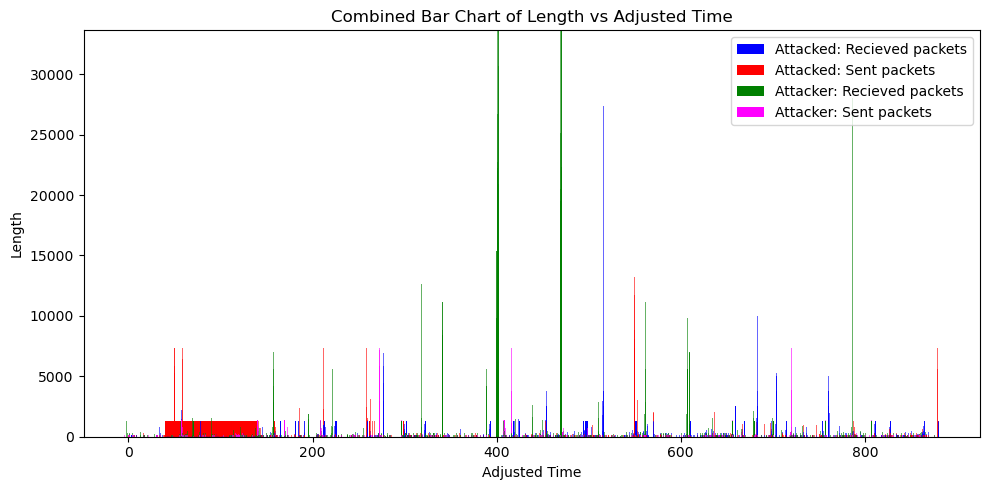

In [41]:
attacked, attacker = read_together()
align_and_plot(attacked, attacker)

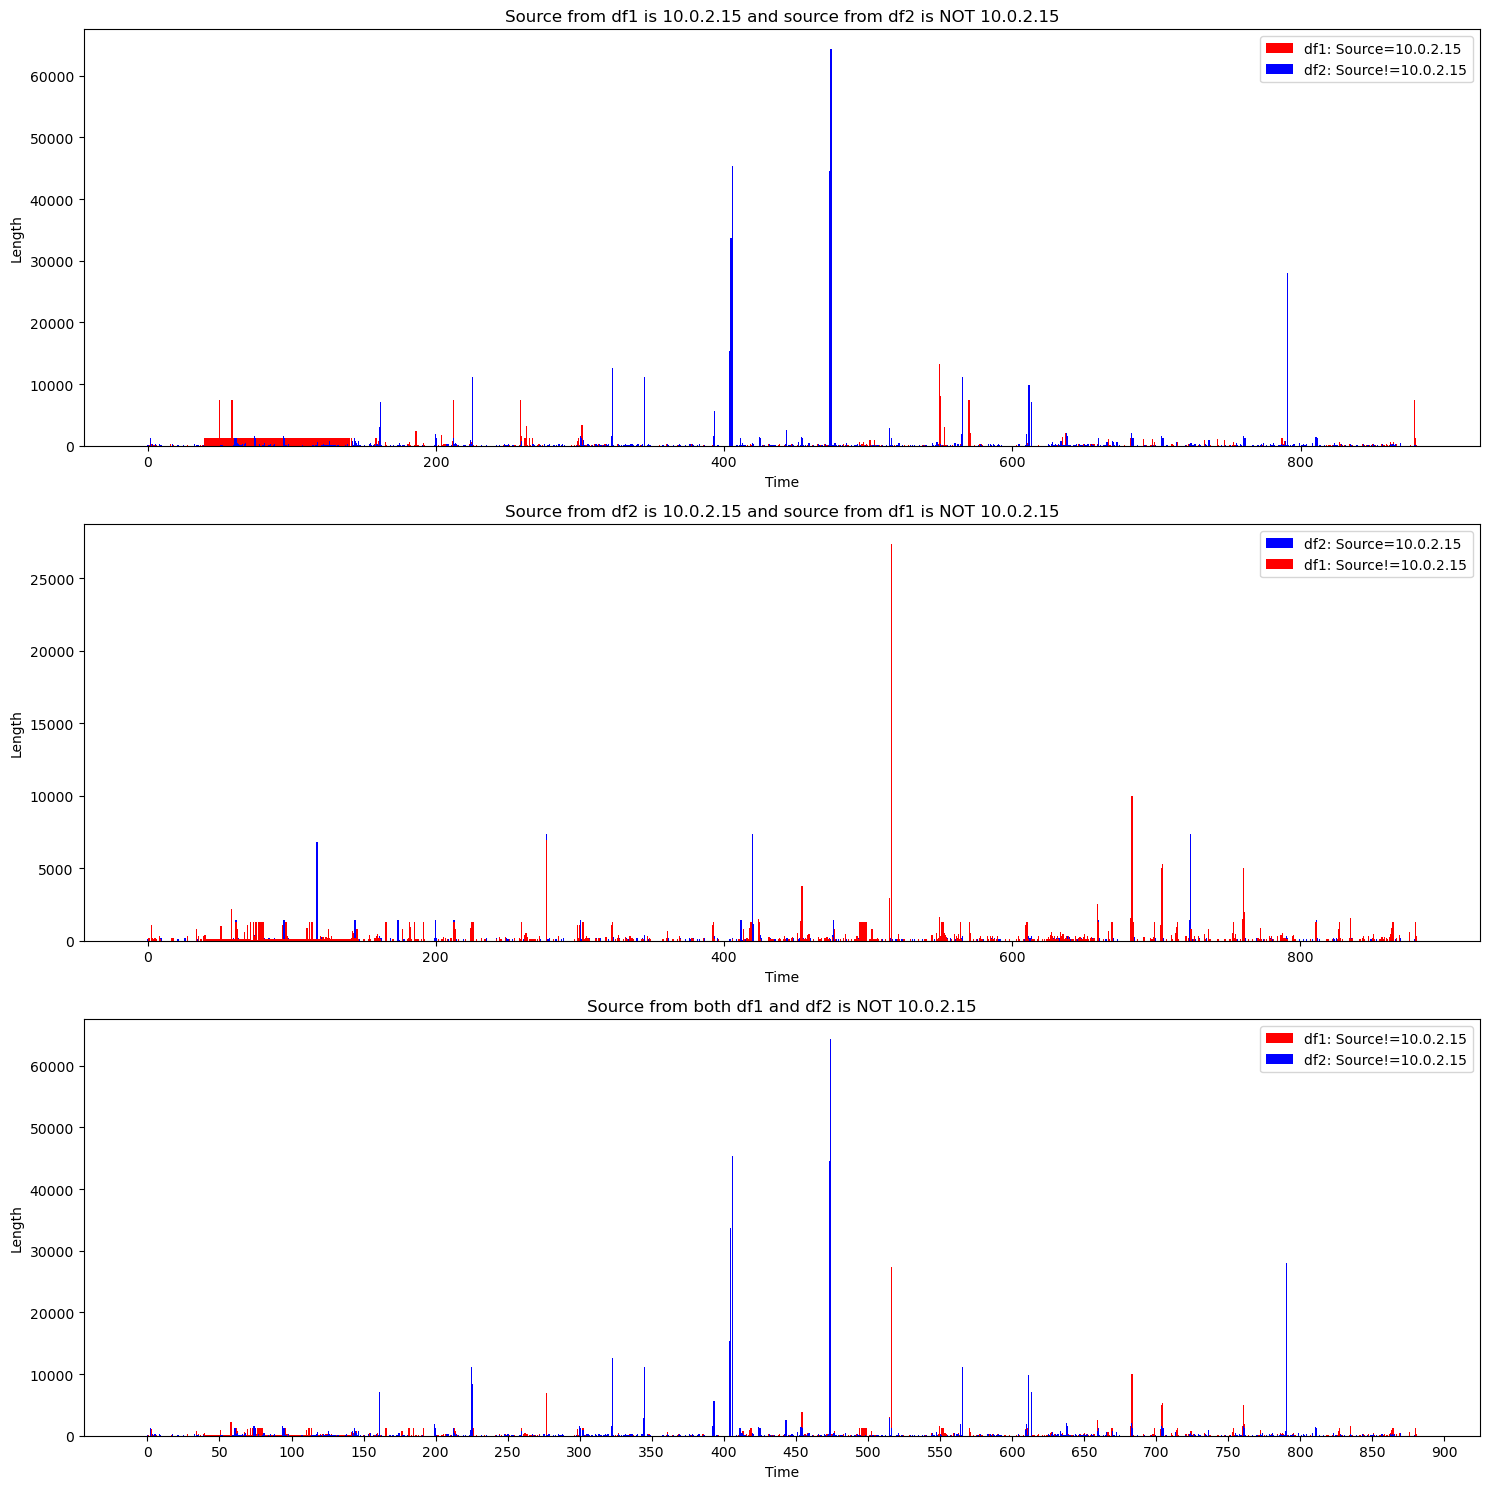

In [42]:
plot_bar_graphs(attacked, attacker)

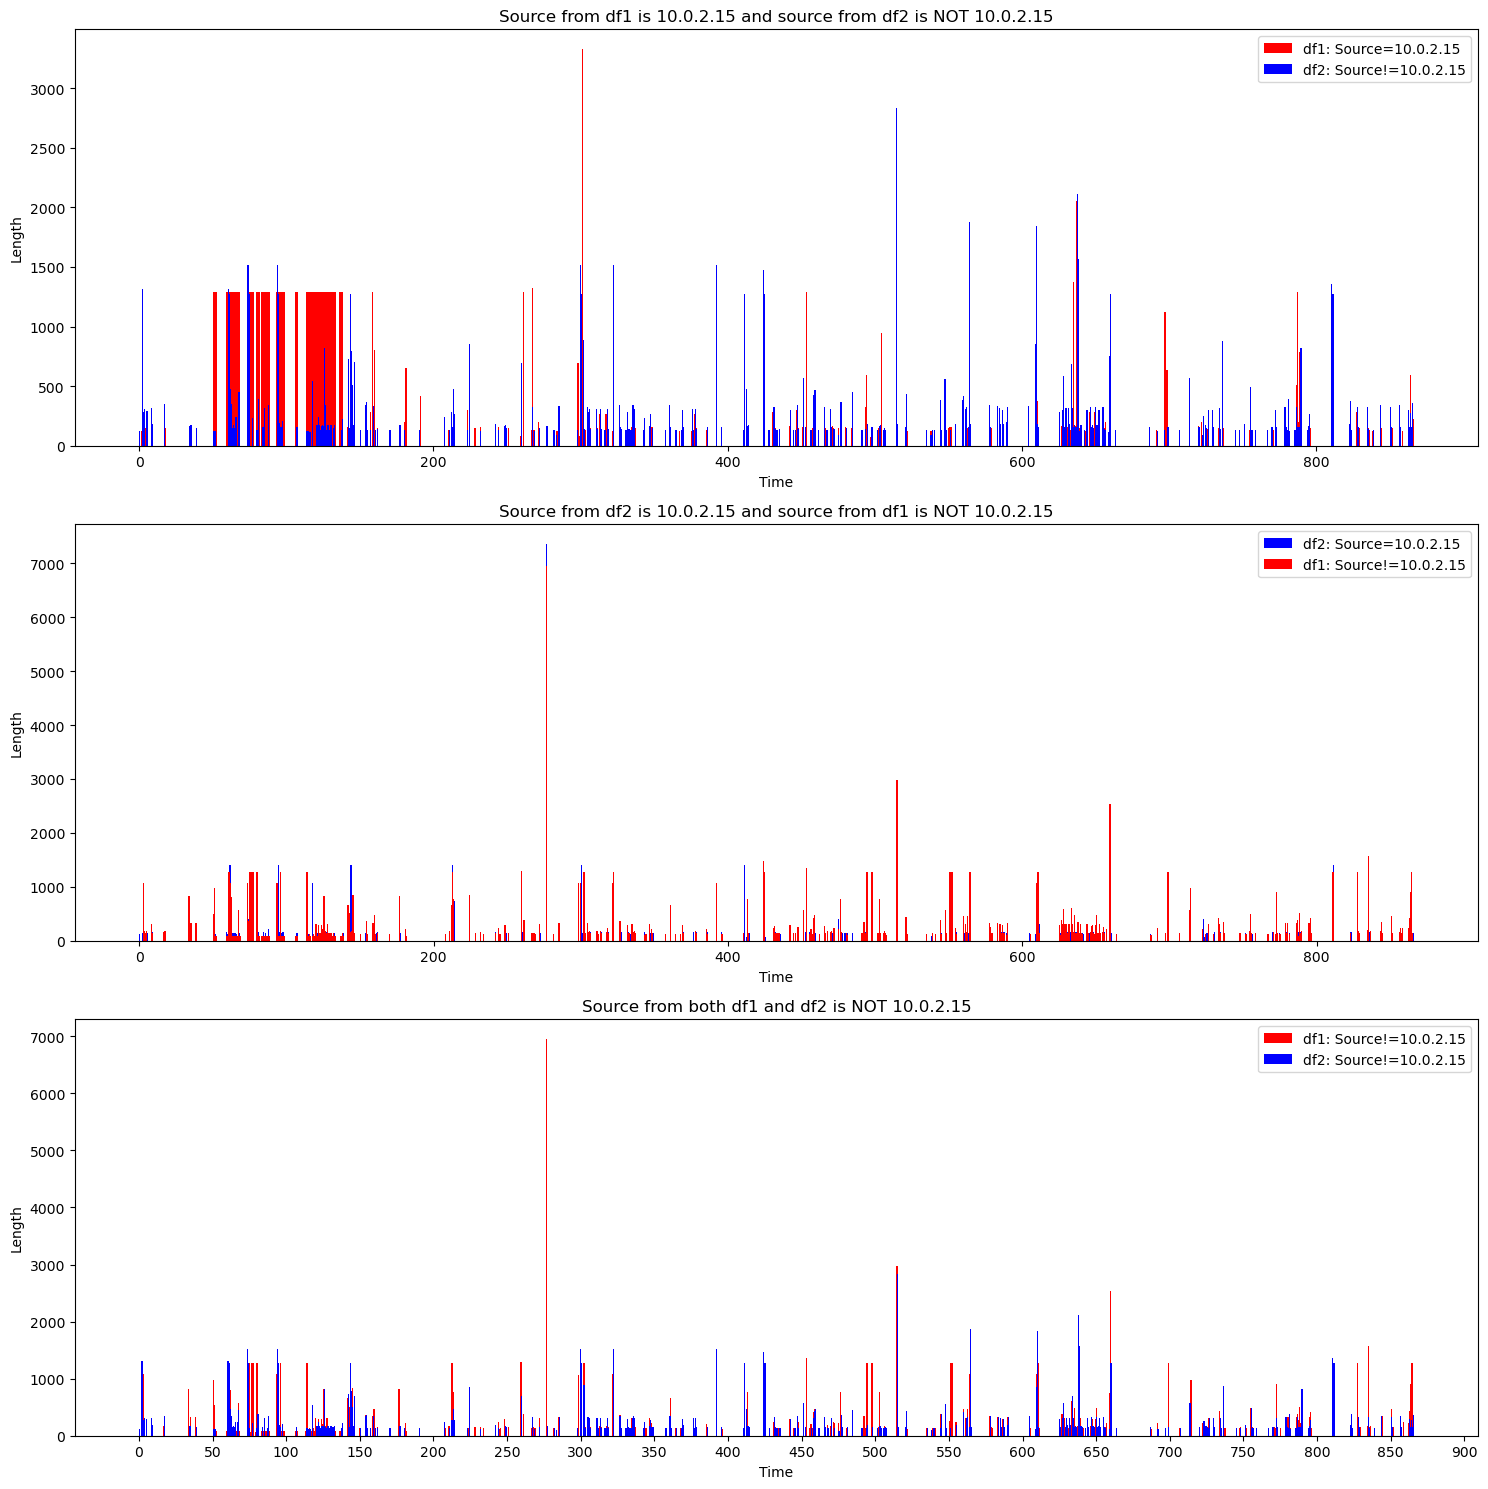

In [43]:
df1, df2 = attacked, attacker

# First, apply the shared seconds filtering function
df1_shared, df2_shared = filter_shared_seconds(df1, df2)

# Then apply the max length difference filtering function
df1_final, df2_final = filter_max_length_difference(df1_shared, df2_shared)

plot_bar_graphs(df1_final, df2_final)

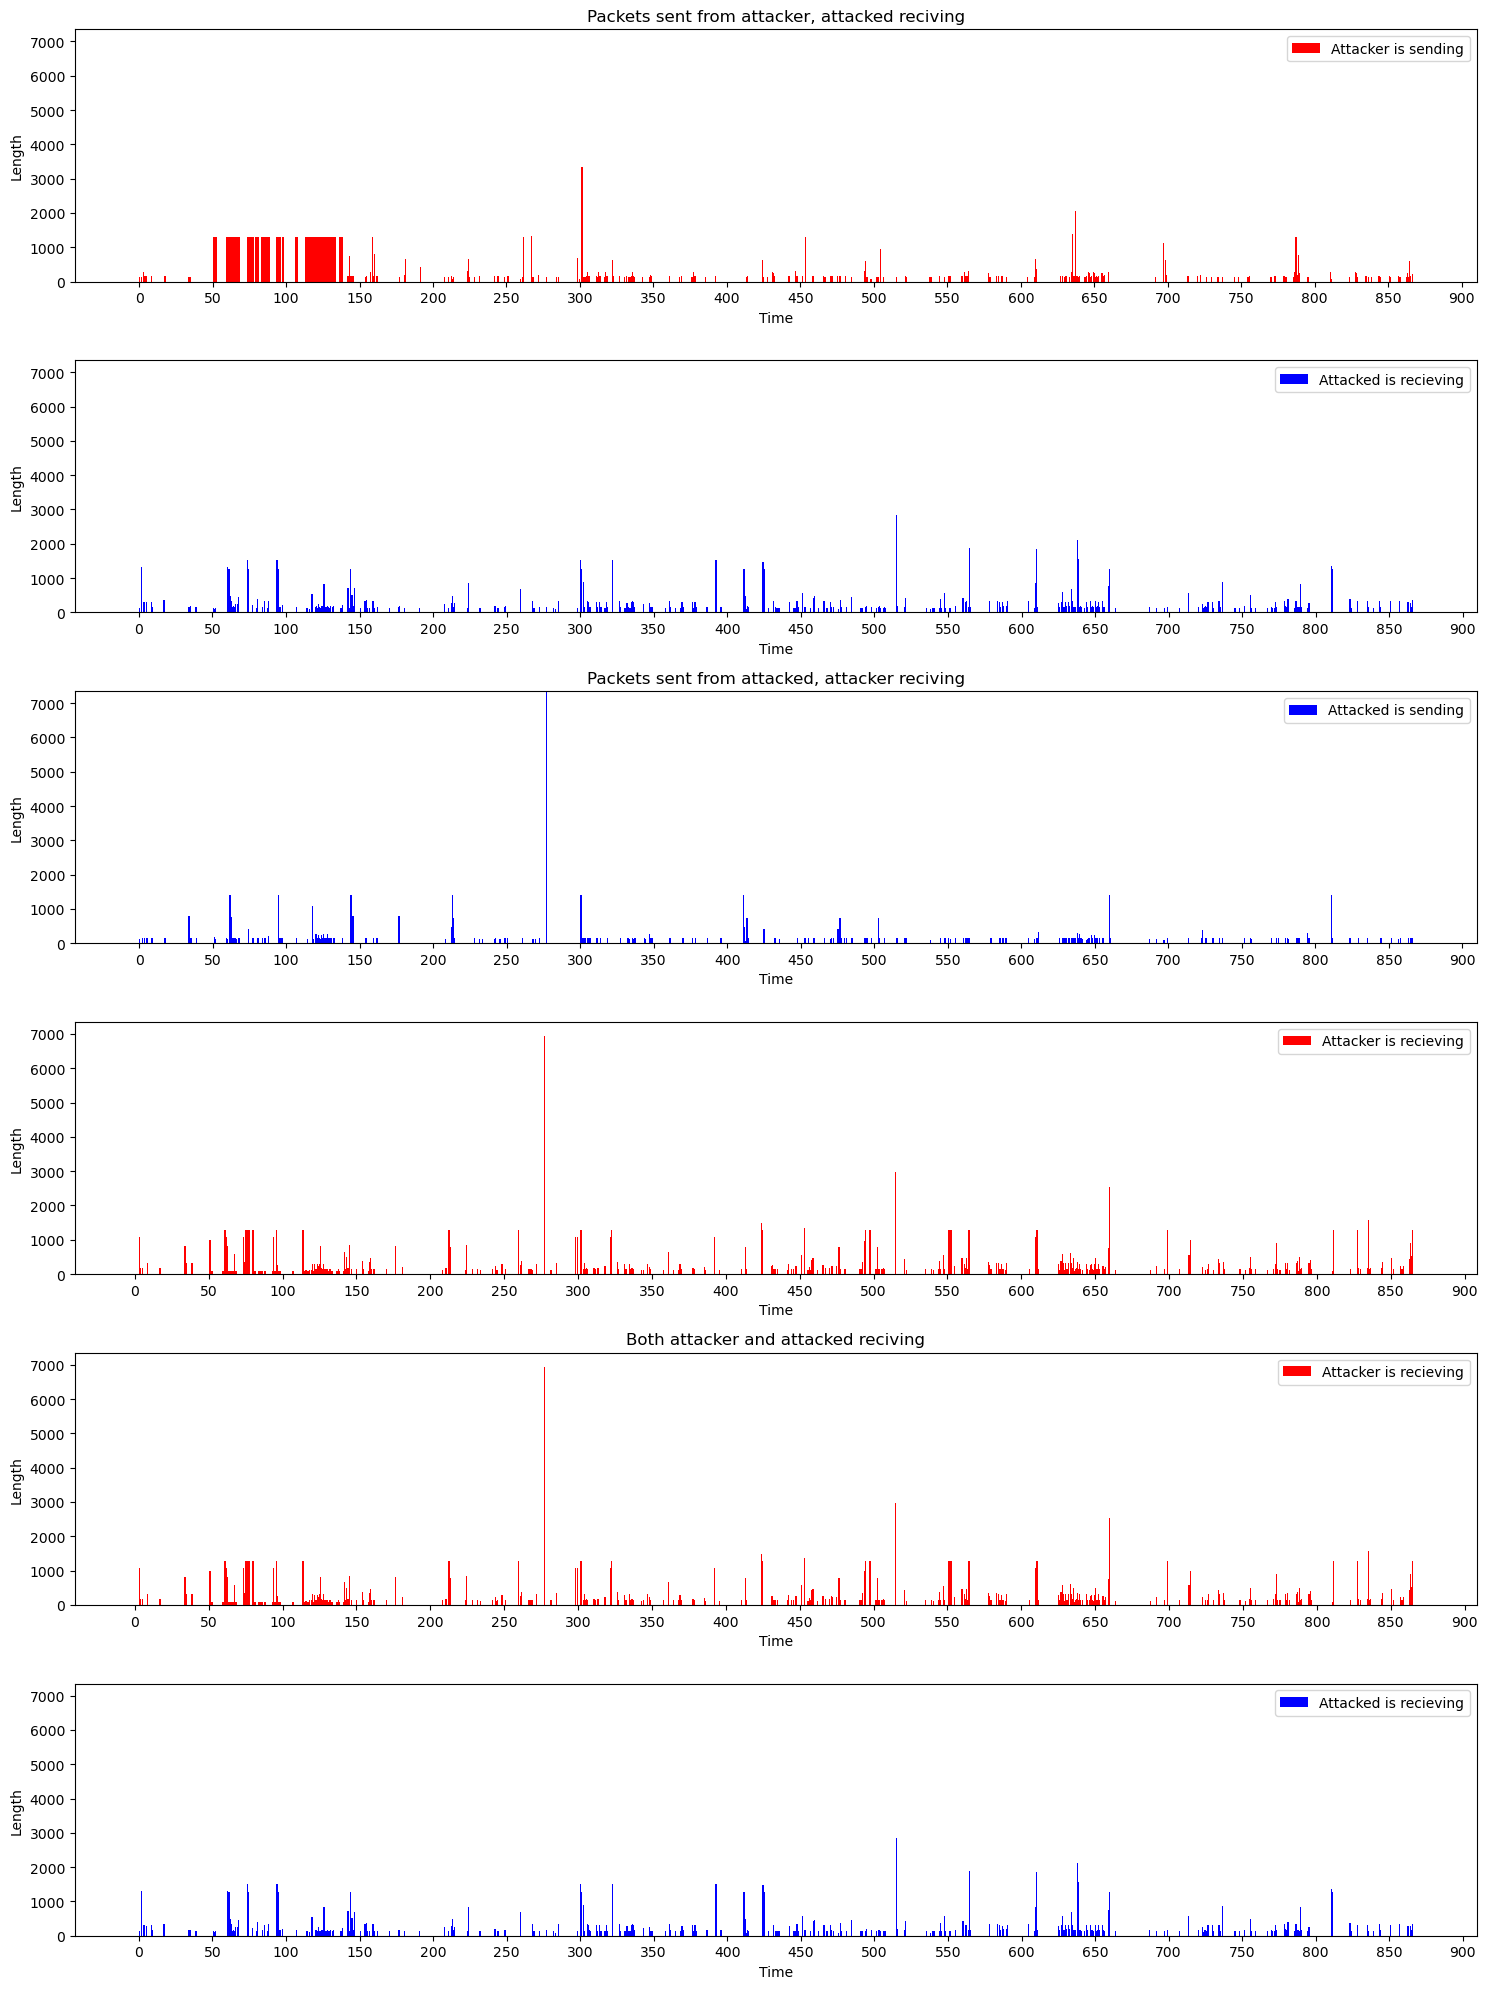

In [44]:
plot_bar_graphs_separated(df1_final, df2_final)

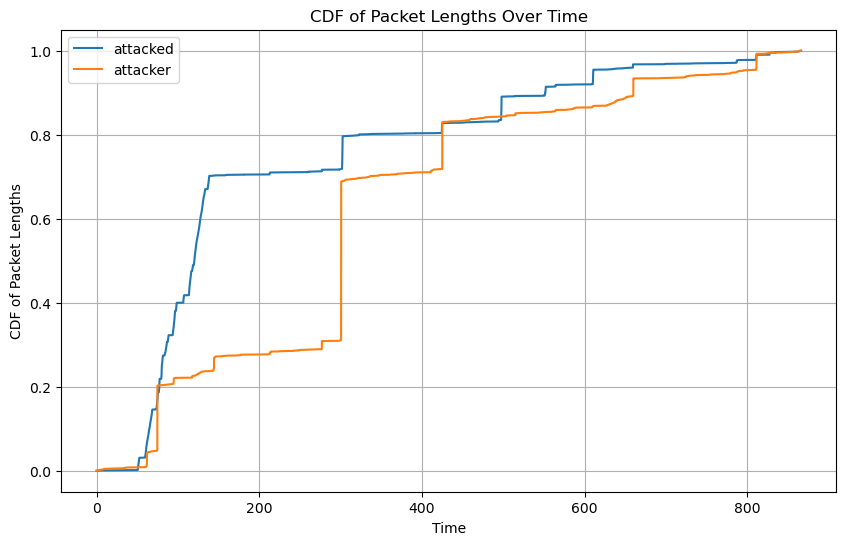

In [45]:
plot_cdfs_on_same_graph(df1_final, df2_final)

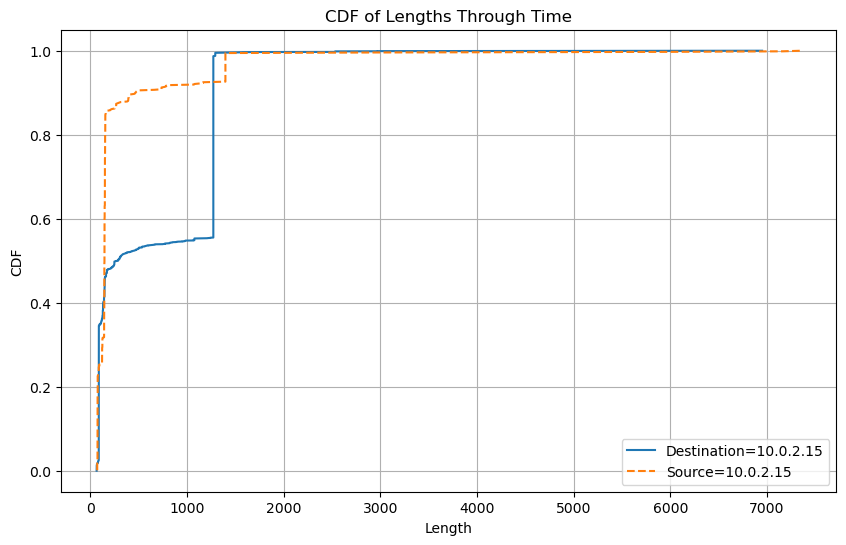

In [46]:
plot_cdfs(df1_final, df2_final)

In [47]:
correlation_between_cdfs(df1_final, df2_final)

Pearson correlation between CDFs: 0.9271
